In [1]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [113]:
raw_df = pd.read_csv('AAPL.csv')
#raw_df.rename(columns={'Close': 'Closing Price', 'Adj Close': 'Adj Closing Price'}, inplace=True)
raw_df['Date'] = raw_df['Date'].apply(pd.to_datetime)
raw_df.set_index('Date',inplace=True)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2016-04-25 to 2021-04-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


## Create a Univariate dataset(Closing price and time)

In [114]:
X_uni = raw_df['Close']
X_uni.tail(30)

Date
2021-03-12    121.029999
2021-03-15    123.989998
2021-03-16    125.570000
2021-03-17    124.760002
2021-03-18    120.529999
2021-03-19    119.989998
2021-03-22    123.389999
2021-03-23    122.540001
2021-03-24    120.089996
2021-03-25    120.589996
2021-03-26    121.209999
2021-03-29    121.389999
2021-03-30    119.900002
2021-03-31    122.150002
2021-04-01    123.000000
2021-04-05    125.900002
2021-04-06    126.209999
2021-04-07    127.900002
2021-04-08    130.360001
2021-04-09    133.000000
2021-04-12    131.240005
2021-04-13    134.429993
2021-04-14    132.029999
2021-04-15    134.500000
2021-04-16    134.160004
2021-04-19    134.839996
2021-04-20    133.110001
2021-04-21    133.500000
2021-04-22    131.940002
2021-04-23    134.320007
Name: Close, dtype: float64

Text(0, 0.5, 'Closing Prices')

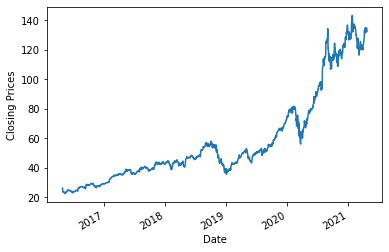

In [115]:
%matplotlib inline

X_uni.plot()
#X_uni.tail(60).plot()
plt.xlabel('Date')
plt.ylabel('Closing Prices')

## Split into training and testing

In [116]:
forecast_length = 30
X_uni_train = X_uni[:-forecast_length]
X_uni_test = X_uni[-forecast_length:]

print(X_uni_train.head())
print(X_uni_test.head())

Date
2016-04-25    26.270000
2016-04-26    26.087500
2016-04-27    24.455000
2016-04-28    23.707500
2016-04-29    23.434999
Name: Close, dtype: float64
Date
2021-03-12    121.029999
2021-03-15    123.989998
2021-03-16    125.570000
2021-03-17    124.760002
2021-03-18    120.529999
Name: Close, dtype: float64


## Naive Forecast

In [117]:
naive_forecast = X_uni_test.copy()

In [118]:
listof = X_uni[1228:1258].values
to_rep = naive_forecast.values
naive_forecast.replace(to_rep,listof,inplace=True)

[121.959999 121.029999 123.989998 125.57     124.760002 120.529999
 119.989998 123.389999 122.540001 120.089996 120.589996 121.209999
 121.389999 119.900002 122.150002 123.       125.900002 126.209999
 127.900002 130.360001 133.       131.240005 134.429993 132.029999
 134.5      134.160004 134.839996 133.110001 133.5      131.940002]


In [119]:
naive_forecast.head()


Date
2021-03-12    121.959999
2021-03-15    121.029999
2021-03-16    123.989998
2021-03-17    125.570000
2021-03-18    124.760002
Name: Close, dtype: float64

In [120]:
X_uni_test.head()

Date
2021-03-12    121.029999
2021-03-15    123.989998
2021-03-16    125.570000
2021-03-17    124.760002
2021-03-18    120.529999
Name: Close, dtype: float64

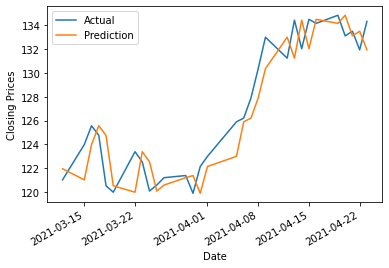

In [123]:
%matplotlib inline

X_uni_test.plot(label='Actual')
naive_forecast.plot(label='Prediction')
#X_uni.tail(0).plot(label='Actual')
#naive_forecast.tail(10).plot(label='Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend()

In [124]:
errors = naive_forecast - X_uni_test
abs_errors = np.abs(errors)
mae = abs_errors.mean()
print(mae)

1.6846655999999973
